In [1]:
import pyoti.sparse as oti
import pyoti.core as coti
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Computer Modern Roman",
    "font.size": 12,
    "font.sans-serif": ["Helvetica"]
})

In [2]:
coti.ndir_total(22,2)

276

In [3]:
def fun1(x,a):
    f = oti.zeros((1,1))
    f[0,0] = oti.cos(x * a) - x / a
    return f

def Jfun1(x,fun,a):
    f = oti.zeros((1,1))
    f[0,0] = -a*oti.sin(x * a) - 1 / a
    return f

def fun2(X,r,m,b):
    #INTERSECTION BETWEEN CURVES.
    f = oti.zeros((2,1))
    x = X[0,0].copy()
    y = X[1,0].copy()
    f[0,0] = x**2 + y**2 - r**2 
    f[1,0] = y - ( m * x + b )
    return f

def fun2_curves(x,r,m,b):
    #CURVES.
    y = oti.zeros((3,1))
    y[0,0] =  oti.sqrt(r**2 - x**2)
    y[1,0] = -oti.sqrt(r**2 - x**2)
    y[2,0] = m * x + b
    return y

In [4]:
# utils
def newton_otisis(func, jaco, x, tol, maxiter=50, args=()):
    error = 1e30
    n = 0
    nx = x.shape[0]
    dx = oti.zeros( (nx,1), order=x.order)
    argv = (func,)+args
    while error > tol:
        if n==maxiter:
            print("Did not converge. ", maxiter, "iters.")
            break
        mJ = -jaco(x,*argv)
#         print(mJ.shape)
        f_eval = func(x,*args)
#         print(f_eval.shape)
        dx = oti.dot(oti.inv(mJ),f_eval)
        error = oti.norm(dx).get_deriv(0)        
        x += dx
        n += 1
#     print("niter: ",n)
#     print("rel_err:",(oti.norm(dx)/oti.norm(x)).get_deriv(0))
    return x

def newton_otisis_verbose(func, jaco, x, tol, maxiter=50, args=()):
    error = 1e30
    n = 0
    nx = x.shape[0]
    dx = oti.zeros( (nx,1), order=x.order)
    argv = (func,)+args
    while error > tol:
        if n==maxiter:
            print("Did not converge. ", maxiter, "iters.")
            break
        print("\n"+"="*20,n)
        mJ = -jaco(x,*argv)
#         print(mJ.shape)
        f_eval = func(x,*args)
        
        dx = oti.dot(oti.inv(mJ),f_eval)
        x += dx
        error = abs(oti.norm(dx).real/oti.norm(x).real)
        
        
        print("ITER:",n)
        print("dx(j):",dx)
        print("J(j):",-mJ)
        print("f(j):",f_eval)
        print("x(j+1):",x)
        print("error: {0:g}".format(error) )
        n += 1
#     print("niter: ",n)
#     print("rel_err:",(oti.norm(dx)/oti.norm(x)).get_deriv(0))
    return x


def newton_otisis_verbose_error(func, jaco, x, tol, maxiter=50, args=()):
    error = 1e30
    n = 0
    nx = x.shape[0]
    dx = oti.zeros( (nx,1), order=x.order)
    argv = (func,)+args
    stats = {}
    stats['dx']    = []
    stats['x']     = []
    stats['error'] = []
    stats['f']     = []
    stats['J']     = []
    while error > tol:
        if n==maxiter:
            print("Did not converge. ", maxiter, "iters.")
            break
        # end if 
        mJ = -jaco(x,*argv)
        f_eval = func(x,*args)
        
        dx = oti.dot(oti.inv(mJ),f_eval)
        x += dx
        error = abs(oti.norm(dx).real/oti.norm(x).real)
        
        stats['dx'].append(dx)
        stats['x'].append(x)
        stats['error'].append(error)
        stats['f'].append(f_eval)
        stats['J'].append(mJ)
        
        n += 1
    # end while
    return x,stats

def j_DF (x, *arg2):
    h = 1e-8
    nx = x.shape[0]
    J = oti.zeros((nx,nx), order=x.order)
    for i in range(nx):
        xh = x.copy()
        xh[i,0]+= h
        dfdxi = (func(xh,*args) - func(x,*args))/h
        for j in range(nx):
            J[j,i] = dfdxi[j,0]
    return J

def j_oti (x, *argv):
    
    nx = x.shape[0]
    func = argv[0]
    args = argv[1:]
    active_bases = func(x,*args).get_active_bases()
    
    if len(active_bases)==0:
        next_base = 1 
    else:
        next_base = max(active_bases) + 1
    # end if 
    
    e_x = oti.zeros((nx,1), order=x.order+1)
    
    for i in range(nx):
        e_x[i] = oti.e(next_base + i, order=x.order+1)  
    # end for 
    
    J = oti.zeros((nx,nx), order=x.order)
    fun = func(x+e_x, *args) 
#     print("f(j)[jaco]:\n",fun)
    
    for n in range(nx):
        J_col = fun.extract_deriv(next_base + n)
        for j in range(nx):
            J_col = J_col.truncate(next_base + j)
        # end for 
        for m in range(nx):
            J[m,n] = J_col[m,0]
        # end for 
    # end for 
    
    return J

In [5]:
x0 = oti.array([.2])
a=5+oti.e(1, order = 5)
x = newton_otisis_verbose(fun1,j_oti,x0,1e-6, args = (a,))


==================== 0
ITER: 0
dx(j): matso< shape: (1, 1), 
 - Column 0
(0,0) 0.113515 - 0.0709283 * e([1]) + 0.0179566 * e([[1,2]]) - 0.00405849 * e([[1,3]]) + ... 
>
J(j): matso< shape: (1, 1), 
 - Column 0
(0,0) -4.40735 - 1.34177 * e([1]) - 0.0319134 * e([[1,2]]) + 0.0220314 * e([[1,3]]) + ... 
>
f(j): matso< shape: (1, 1), 
 - Column 0
(0,0) 0.500302 - 0.160294 * e([1]) - 0.012406 * e([[1,2]]) + 0.00144196 * e([[1,3]]) + ... 
>
x(j+1): matso< shape: (1, 1), 
 - Column 0
(0,0) 0.313515 - 0.0709283 * e([1]) + 0.0179566 * e([[1,2]]) - 0.00405849 * e([[1,3]]) + ... 
>
error: 0.362073

==================== 1
ITER: 1
dx(j): matso< shape: (1, 1), 
 - Column 0
(0,0) -0.0114392 + 0.0151589 * e([1]) - 0.00813294 * e([[1,2]]) + 0.00243941 * e([[1,3]]) + ... 
>
J(j): matso< shape: (1, 1), 
 - Column 0
(0,0) -5.19997 - 0.959333 * e([1]) - 0.00394277 * e([[1,2]]) - 0.00145466 * e([[1,3]]) + ... 
>
f(j): matso< shape: (1, 1), 
 - Column 0
(0,0) -0.0594833 + 0.067852 * e([1]) - 0.0277937 * e([[

In [6]:
oti.set_printoptions(float_format='.16f')
x[0,0].rom_eval([1],[2])

0.2197260089505207

In [7]:
x,stats=newton_otisis_verbose_error(fun1,j_oti,x0,1e-6, args = (a,))


In [8]:
x[0,0].get_deriv([1]).real

-0.05575843363566339

In [9]:
(-0.05575843405+0.05575843363566339)/0.05575843363566339

-7.430922636716421e-09

In [10]:
stats['error']

[0.3620726419044946,
 0.03786846913412071,
 2.32425557975014e-05,
 2.3730797904870582e-11]

<IPython.core.display.Javascript object>


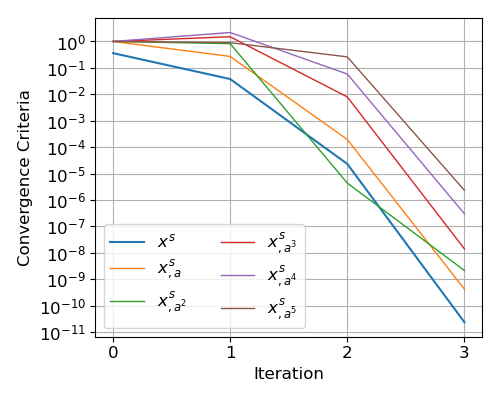

findfont: Font family ['Computer Modern Roman'] not found. Falling back to DejaVu Sans.


0.3620726419044946 - 0.1443217458101003 * e([1]) + 0.0038865471733676 * e([[1,2]]) + 0.0008872487902050 * e([[1,3]]) + ... 
0.0378684691341207 - 0.0431911686718379 * e([1]) + 0.0177180292070203 * e([[1,2]]) - 0.0031968120890693 * e([[1,3]]) + ... 
0.0000232425557975 - 0.0000318134822156 * e([1]) - 0.0000067706225192 * e([[1,2]]) + 0.0000429722176191 * e([[1,3]]) + ... 
0.0000000000237308 - 0.0000000000733819 * e([1]) + 0.0000000000558231 * e([[1,2]]) + 0.0000000000894674 * e([[1,3]]) + ... 
0.3620726419044946 - 0.1443217458101003 * e([1]) + 0.0038865471733676 * e([[1,2]]) + 0.0008872487902050 * e([[1,3]]) + ... 
0.0378684691341207 - 0.0431911686718379 * e([1]) + 0.0177180292070203 * e([[1,2]]) - 0.0031968120890693 * e([[1,3]]) + ... 
0.0000232425557975 - 0.0000318134822156 * e([1]) - 0.0000067706225192 * e([[1,2]]) + 0.0000429722176191 * e([[1,3]]) + ... 
0.0000000000237308 - 0.0000000000733819 * e([1]) + 0.0000000000558231 * e([[1,2]]) + 0.0000000000894674 * e([[1,3]]) + ... 
0.362072

In [11]:
plt.figure(figsize=(5,4))

nIter = len(stats['error'])
plt.semilogy(range(nIter),stats['error'],label=r'$x^s$')

for i in range(1,5+1):
    err_plot = []
    for j in range(len(stats['dx'])):
        dx_i=stats['dx'][j]
        x_i =stats['x'][j]
        err_oti = (oti.norm(dx_i)/oti.norm(x_i))
        err = abs( np.linalg.norm( 
                        dx_i.get_deriv([1]*i) 
                        )/np.linalg.norm(
                        x_i.get_deriv([1]*i)
        ))
        print(        err_oti)
        err_plot.append(err)
#         err_plot.append(err_oti.get_deriv([1]*i))
    # end for
    label_a = r'${{x}}^{{s}}_{{,a{0}}}$'
    if i == 1:
        label_a = label_a.format("")
    else:
        label_a = label_a.format("^{0}".format(i))
    # end if      
    plt.semilogy(range(nIter),err_plot,lw=1,label=label_a)
# end for 
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.LogLocator(numticks=17))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.legend(ncol=2)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Convergence Criteria')
plt.tight_layout()
plt.savefig('pdf/err_singVar_convergence_tol-6.pdf',dpi=300)
plt.show()

In [12]:
x_new = newton_otisis(fun1,Jfun1,x0,1e-8, args = (a+2,))
x_new[0,0].real

0.2199107619571356

In [13]:
(0.2197260089505207-0.2199107619571356)/(0.2199107619571356)

-0.000840127172361507

In [14]:
x1 = newton_otisis_verbose(fun1,Jfun1,x0,1e-8, args = (a,))


==================== 0
ITER: 0
dx(j): matso< shape: (1, 1), 
 - Column 0
(0,0) 0.1135153202977346 - 0.0709282613284753 * e([1]) + 0.0179565626693130 * e([[1,2]]) - 0.0040584909633697 * e([[1,3]]) + ... 
>
J(j): matso< shape: (1, 1), 
 - Column 0
(0,0) -4.4073549240394829 - 1.3417732906760362 * e([1]) - 0.0319133626928383 * e([[1,2]]) + 0.0220314350686122 * e([[1,3]]) + ... 
>
f(j): matso< shape: (1, 1), 
 - Column 0
(0,0) 0.5003023058681397 - 0.1602941969615793 * e([1]) - 0.0124060461173628 * e([[1,2]]) + 0.0014419613130772 * e([[1,3]]) + ... 
>
x(j+1): matso< shape: (1, 1), 
 - Column 0
(0,0) 0.3135153202977347 - 0.0709282613284753 * e([1]) + 0.0179565626693130 * e([[1,2]]) - 0.0040584909633697 * e([[1,3]]) + ... 
>
error: 0.362073

==================== 1
ITER: 1
dx(j): matso< shape: (1, 1), 
 - Column 0
(0,0) -0.0114391616884495 + 0.0151589218296751 * e([1]) - 0.0081329426032505 * e([[1,2]]) + 0.0024394092778334 * e([[1,3]]) + ... 
>
J(j): matso< shape: (1, 1), 
 - Column 0
(0,0) -5

In [15]:
(x1-x).get_deriv([[1,20]])

array([[0.]])

In [16]:
fun1(x,a).real

array([[-1.5959456e-16]])

In [17]:
# ROM a = 1, ∆a = -4
anew = 1
Δa = anew - a.real
xrom1 = x.rom_eval([1],[Δa])
print(xrom1)

print("Evaluating function at new value found:")
fun1(xrom1,anew)

# Solution: 0.73908513

matso< shape: (1, 1), 
 - Column 0
(0,0) 0.8842239929149360
>
Evaluating function at new value found:


matso< shape: (1, 1), 
 - Column 0
(0,0) -0.2503341186528876
>

In [18]:
# ROM a = 2, ∆a = -3
anew = 2
Δa = anew - a.real
xrom1 = x.rom_eval([1],[Δa])
print(xrom1)

print("Evaluating function at new value found:")
fun1(xrom1,anew)

# Solution: 0.73908513

matso< shape: (1, 1), 
 - Column 0
(0,0) 0.6300059536544604
>
Evaluating function at new value found:


matso< shape: (1, 1), 
 - Column 0
(0,0) -0.0091974053044385
>

<IPython.core.display.Javascript object>


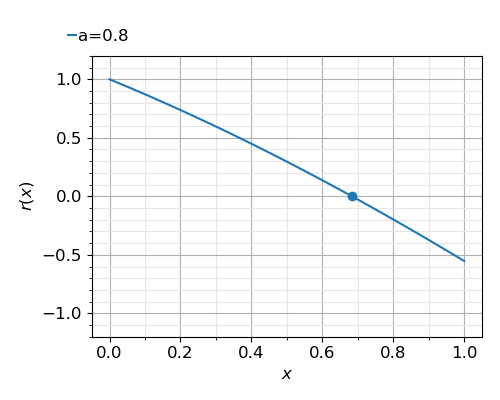

In [19]:
a_vec = [0.8,]
x_vec = np.linspace(0,1.0,1000)
f_vec = np.zeros((len(a_vec),x_vec.size))

plt.figure(figsize=(5,4))
i=0
x = oti.zeros((1,1))
x0 = oti.array([.2])
for a in a_vec:
    j = 0
    for xj in x_vec:
        x[0,0] = x_vec[j]
        f_eval = fun1(x,a)
        f_vec[i,j] = f_eval[0,0].real
        j+=1        
    # end for 
    ap = a+oti.e(1)
    x_root = newton_otisis(fun1,j_oti,x0,1e-6, args = (ap,))
    f_root = fun1(x_root,ap)
    plt.plot(x_root[0,0].real,f_root[0,0].real,'o'+'C'+str(i),lw=1.5)#,label="a={0:.1f}".format(a))
    plt.plot(x_vec,f_vec[i,:],'C'+str(i),lw=1.5,label="a={0:.1f}".format(a))
    i += 1
# end for

plt.legend(ncol=5,handlelength=0.5,loc='upper left',handletextpad = 0.1,columnspacing=0.5, bbox_to_anchor=(-0.1, 1.15),frameon=False)

plt.xlabel("$x$")
# plt.ylabel("$f(x)$")
plt.ylabel("$r(x)$")
# plt.title("$f(x)=\cos(ax)+x/a$")
# plt.legend()
plt.grid()
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
plt.axis([None,None,-1.2,1.2])
plt.grid(which='minor', color=(0.9,0.9,0.9))
plt.tight_layout()

plt.savefig('png/fun1_cos_sing.png',dpi=150)
plt.savefig('pdf/fun1_cos_sing.pdf',dpi=150)
plt.show()

<IPython.core.display.Javascript object>


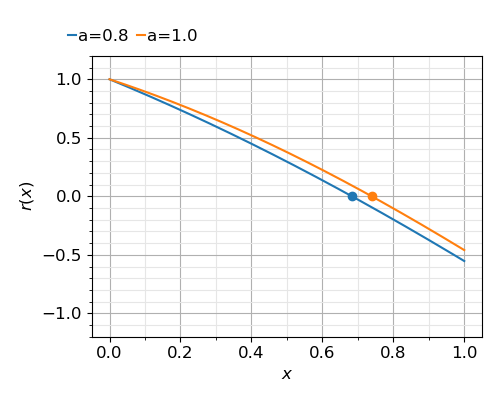

In [20]:
a_vec = [0.8,1]
x_vec = np.linspace(0,1.0,500)
f_vec = np.zeros((len(a_vec),x_vec.size))

plt.figure(figsize=(5,4))
i=0
x = oti.zeros((1,1))
x0 = oti.array([.2])
for a in a_vec:
    j = 0
    for xj in x_vec:
        x[0,0] = x_vec[j]
        f_eval = fun1(x,a)
        f_vec[i,j] = f_eval[0,0].real
        j+=1        
    # end for 
    ap = a+oti.e(1)
    x_root = newton_otisis(fun1,j_oti,x0,1e-6, args = (ap,))
    f_root = fun1(x_root,ap)
    plt.plot(x_root[0,0].real,f_root[0,0].real,'o'+'C'+str(i),lw=1.5)#,label="a={0:.1f}".format(a))
    plt.plot(x_vec,f_vec[i,:],'C'+str(i),lw=1.5,label="a={0:.1f}".format(a))
    i += 1
# end for

plt.xlabel("$x$")
plt.ylabel("$r(x)$")
# plt.title("$f(x)=\cos(ax)+x/a$")
plt.legend(ncol=5,handlelength=0.5,loc='upper left',handletextpad = 0.1,columnspacing=0.5, bbox_to_anchor=(-0.1, 1.15),frameon=False)
plt.grid()
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
plt.axis([None,None,-1.2,1.2])
plt.grid(which='minor', color=(0.9,0.9,0.9))
plt.tight_layout()

plt.savefig('png/fun1_cos_bi.png',dpi=150)
plt.savefig('pdf/fun1_cos_bi.pdf',dpi=150)
plt.show()

<IPython.core.display.Javascript object>


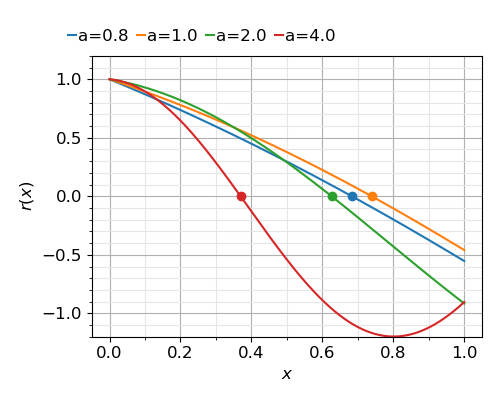

In [21]:
a_vec = [0.8,1,2,4]
x_vec = np.linspace(0,1.0,500)
f_vec = np.zeros((len(a_vec),x_vec.size))

plt.figure(figsize=(5,4))
i=0
x = oti.zeros((1,1))
x0 = oti.array([.2])
for a in a_vec:
    j = 0
    for xj in x_vec:
        x[0,0] = x_vec[j]
        f_eval = fun1(x,a)
        f_vec[i,j] = f_eval[0,0].real
        j+=1        
    # end for 
    ap = a+oti.e(1)
    x_root = newton_otisis(fun1,j_oti,x0,1e-6, args = (ap,))
    f_root = fun1(x_root,ap)
    plt.plot(x_root[0,0].real,f_root[0,0].real,'o'+'C'+str(i),lw=1.5)#,label="a={0:.1f}".format(a))
    plt.plot(x_vec,f_vec[i,:],'C'+str(i),lw=1.5,label="a={0:.1f}".format(a))
    i += 1
# end for

plt.xlabel("$x$")
plt.ylabel("$r(x)$")
# plt.title("$f(x)=\cos(ax)+x/a$")
plt.legend(ncol=5,handlelength=0.5,loc='upper left',handletextpad = 0.1,columnspacing=0.5, bbox_to_anchor=(-0.1, 1.15),frameon=False)
plt.grid()
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
plt.axis([None,None,-1.2,1.2])
plt.grid(which='minor', color=(0.9,0.9,0.9))
plt.tight_layout()


plt.savefig('png/fun1_cos.png',dpi=150)
plt.savefig('pdf/fun1_cos.pdf',dpi=150)
plt.show()

In [22]:
# Plot x vs a
# a_vec = np.linspace(1,5,100)
a_vec = np.linspace(.1,4,100)
x_vec = np.zeros_like(a_vec)

x0 = oti.array([.2])
i=0
for a in a_vec:
    ap = a+oti.e(1)
    x = newton_otisis(fun1,j_oti,x0,1e-6, args = (ap,))
    x_vec[i] = x[0,0].real
    i+=1

In [29]:
x_vec

array([0.099995  , 0.10990189, 0.11980747, 0.12971136, 0.1396131 ,
       0.14951217, 0.15940795, 0.16929975, 0.17918678, 0.18906817,
       0.19894294, 0.20880999, 0.21866813, 0.22851605, 0.23835232,
       0.24817538, 0.25798356, 0.26777504, 0.27754788, 0.28730002,
       0.29702924, 0.30673319, 0.31640938, 0.3260552 , 0.33566789,
       0.34524455, 0.35478216, 0.36427756, 0.37372746, 0.38312848,
       0.39247709, 0.40176968, 0.4110025 , 0.42017176, 0.42927355,
       0.43830389, 0.44725877, 0.45613408, 0.46492572, 0.47362955,
       0.48224139, 0.49075712, 0.49917259, 0.50748371, 0.51568642,
       0.52377675, 0.53175077, 0.53960468, 0.54733477, 0.55493745,
       0.56240927, 0.56974693, 0.57694728, 0.58400735, 0.59092435,
       0.59769568, 0.60431893, 0.61079191, 0.61711263, 0.62327933,
       0.62929044, 0.63514465, 0.64084084, 0.64637813, 0.65175587,
       0.65697359, 0.66203108, 0.66692832, 0.67166549, 0.67624298,
       0.68066138, 0.68492146, 0.68902416, 0.6929706 , 0.69676

<IPython.core.display.Javascript object>


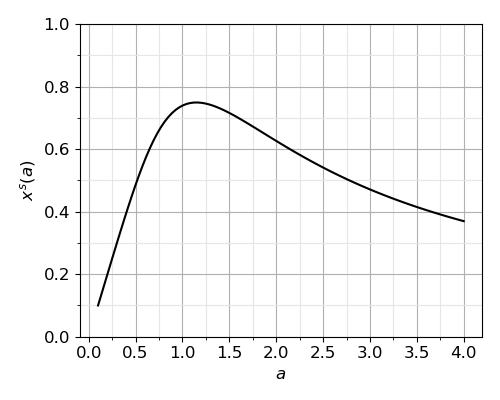

In [86]:
plt.figure(figsize=(5,4))
plt.plot(a_vec,x_vec,'k',lw=1.5)
plt.xlabel("$a$")
plt.ylabel("$x^{s}(a)$")
# plt.title("$x^{s}(a)$")
plt.grid()
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))
# plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
# plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.02))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.5))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.25))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
plt.grid(which='minor',color=(0.9,0.9,0.9))
plt.axis([None,None,0,1])
plt.tight_layout()
plt.savefig('png/root_fun1_cos.png',dpi=150)
plt.savefig('pdf/root_fun1_cos.pdf',dpi=150)
plt.show()

In [25]:
orders = [1,2,5,10]
Δa_vec = np.zeros((len(orders),a_vec.size))
rom_vec = np.zeros((len(orders),a_vec.size))

ordi = 0

for order in orders:
    
    x0 = oti.array([.2])
    
    a = 2 + oti.e(1, order = order)
    x = newton_otisis(fun1,j_oti,x0,1e-6, args = (a,))
    
    Δa_vec[ordi] = a_vec-a.real
    i=0

    for Δa in Δa_vec[ordi]:
        rom = x.rom_eval([1],[Δa])
        rom_vec[ordi,i] = rom[0,0].real
        i+=1
    # end for 
    
    ordi+=1

# end for



<IPython.core.display.Javascript object>


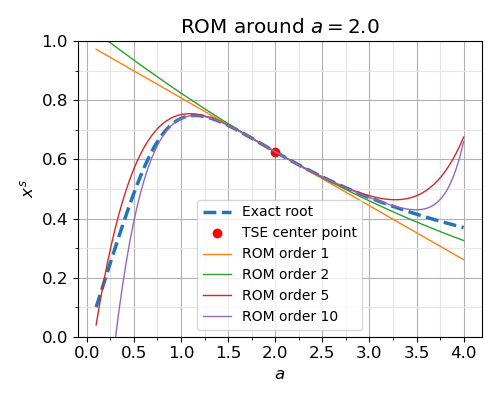

0
1
2
3


In [26]:
plt.figure(figsize=(5,4))
plt.plot(a_vec,x_vec,'--C0',lw=2.5,label = 'Exact root')
plt.plot(a.real,x.real[0,0],'or',lw=1.5,label = 'TSE center point')
i = 0
orders_plt = orders[:]
for order in orders_plt:
    idx = orders.index(order)
    print(idx)
    plt.plot(a_vec,rom_vec[idx,:],'C'+str(i+1),lw=1.0,label='ROM order '+str(order))
    i+=1
# end for 
plt.axis([None,None,0,1.0])
plt.title("ROM around $a={0:.1f}$".format(a.real))
plt.xlabel("$a$")
plt.ylabel("$x^{s}$")
plt.grid()
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))
# plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
# plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.5))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.25))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
plt.grid(which='minor',color=(0.9,0.9,0.9))
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig('png/rom_cos_func_a'+str(int(a.real))+'.png',dpi=150)
plt.savefig('pdf/rom_cos_func_a'+str(int(a.real))+'.pdf',dpi=150)
plt.show()

<IPython.core.display.Javascript object>


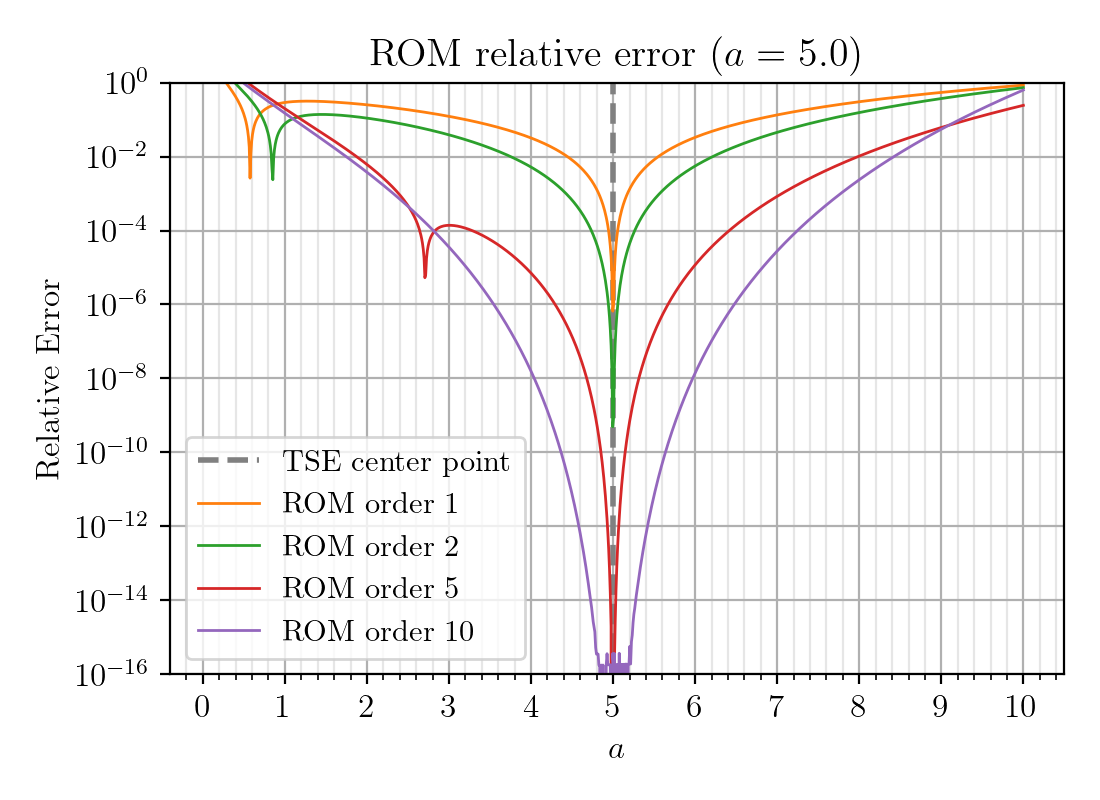

In [26]:
plt.figure(figsize=(5.5,4))
# plt.plot(a_vec,x_vec,'xC0',lw=1.5,label = 'Exact root')
i = 0
orders_plt = orders[:]
plt.semilogy([a.real,a.real],[0,1],'--',color='gray',lw=2.0,label='TSE center point')
for order in orders_plt:
    idx = orders.index(order)
    error = np.abs(rom_vec[idx,:] - x_vec)/np.abs(x_vec)
    plt.semilogy(a_vec,error,'C'+str(i+1),lw=1.0,label='ROM order '+str(order))

    i+=1
# end for 
plt.axis([None,None,None,1.0])
plt.title("ROM relative error ($a={0:.1f}$)".format(a.real))
plt.xlabel("$a$")
plt.ylabel("Relative Error")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10,numticks=15))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
# plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10,numticks=50))
plt.grid()
plt.grid(which='minor',color=(0.9,0.9,0.9))
plt.legend(fontsize=11)
plt.axis([None,None,1e-16,1])
plt.tight_layout()

plt.savefig('png/err_rom_fun1_a'+str(int(a.real))+'.png',dpi=150)
plt.savefig('pdf/err_rom_fun1_a'+str(int(a.real))+'.pdf',dpi=150)
plt.show()

In [27]:
ordi = 0

for order in orders:
    
    x0 = oti.array([.2])
    
    a = 1 + oti.e(1, order = order)
    x = newton_otisis(fun1,j_oti,x0,1e-6, args = (a,))
    
    Δa_vec[ordi] = a_vec-a.real
    i=0

    for Δa in Δa_vec[ordi]:
        rom = x.rom_eval([1],[Δa])
        rom_vec[ordi,i] = rom[0,0].real
        i+=1
    # end for 
    
    ordi+=1

# end for

<IPython.core.display.Javascript object>


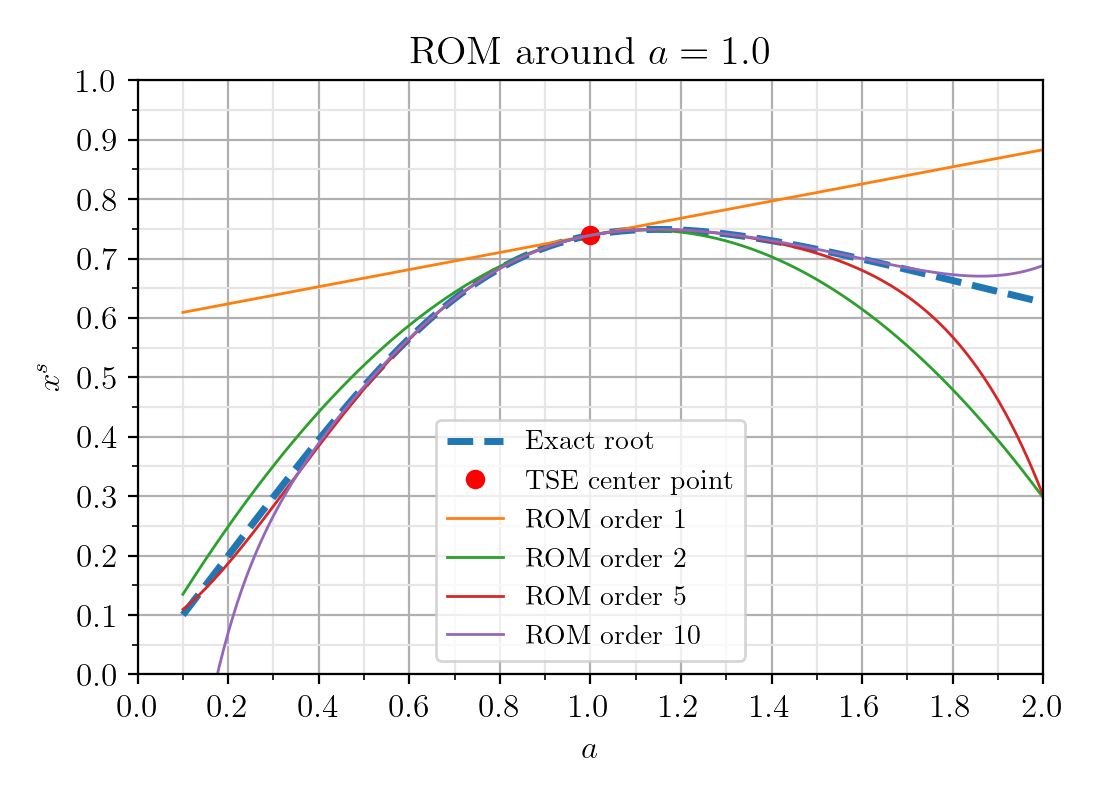

In [28]:
plt.figure(figsize=(5.5,4))
plt.plot(a_vec,x_vec,'--C0',lw=2.5,label = 'Exact root')
plt.plot(a.real,x.real[0,0],'or',lw=1.5,label = 'TSE center point')
i = 0
orders_plt = orders[:]
for order in orders_plt:
    idx = orders.index(order)
    
    plt.plot(a_vec,rom_vec[idx,:],'C'+str(i+1),lw=1.0,label='ROM order '+str(order))
    i+=1
# end for 
plt.axis([None,None,0,1.0])
plt.title("ROM around $a={0:.1f}$".format(a.real))
plt.xlabel("$a$")
plt.ylabel("$x^{s}$")
plt.grid()
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
plt.grid(which='minor',color=(0.9,0.9,0.9))
plt.legend(fontsize=10)
plt.axis([0,2,None,None])
plt.tight_layout()
plt.savefig('png/rom_cos_func_a'+str(int(a.real))+'.png',dpi=150)
plt.savefig('pdf/rom_cos_func_a'+str(int(a.real))+'.pdf',dpi=150)
plt.show()

<IPython.core.display.Javascript object>


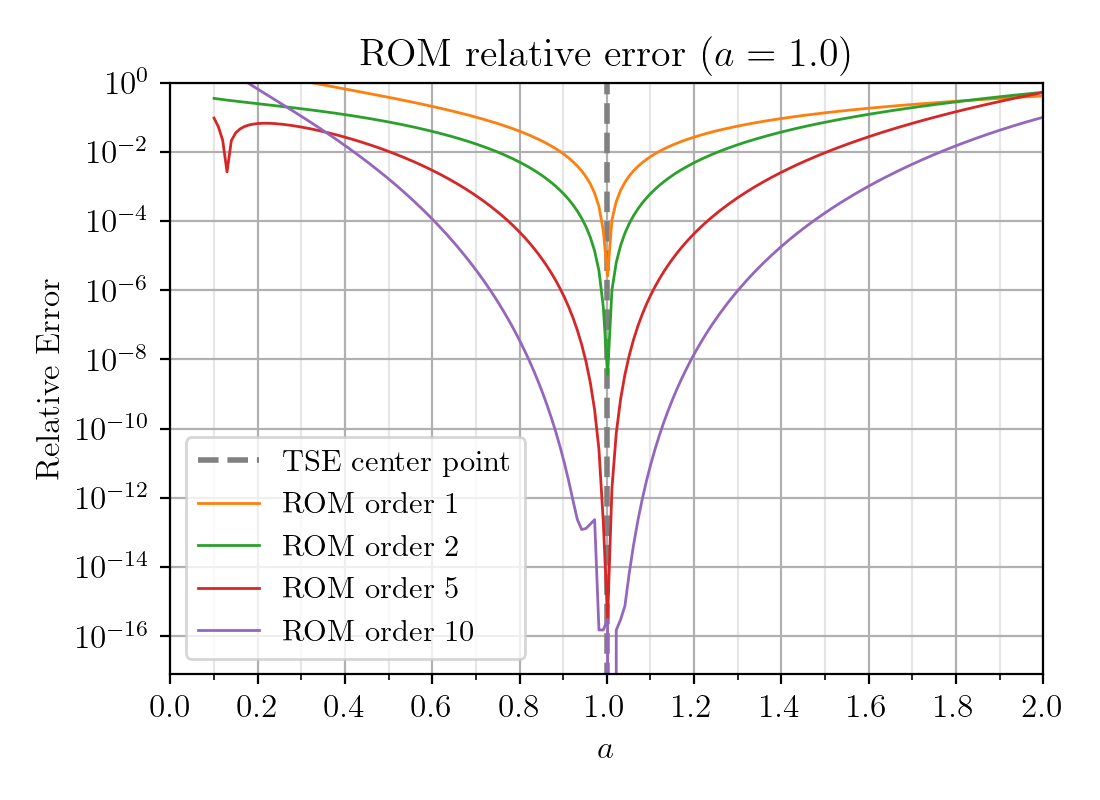

In [29]:
plt.figure(figsize=(5.5,4))
# plt.plot(a_vec,x_vec,'xC0',lw=1.5,label = 'Exact root')
i = 0
orders_plt = orders[:]
plt.semilogy([a.real,a.real],[0,1],'--',color='gray',lw=2.0,label='TSE center point')
for order in orders_plt:
    idx = orders.index(order)
    error = np.abs(rom_vec[idx,:] - x_vec)/np.abs(x_vec)
    plt.semilogy(a_vec,error,'C'+str(i+1),lw=1.0,label='ROM order '+str(order))

    i+=1
# end for 
plt.axis([None,None,None,1.0])
plt.title("ROM relative error ($a={0:.1f}$)".format(a.real))
plt.xlabel("$a$")
plt.ylabel("Relative Error")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10,numticks=15))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
# plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10,numticks=50))
plt.grid()
plt.grid(which='minor',color=(0.9,0.9,0.9))
plt.legend(fontsize=11)

plt.axis([0,2,None,None])
plt.tight_layout()

plt.savefig('png/err_rom_fun1_a'+str(int(a.real))+'.png',dpi=150)
plt.savefig('pdf/err_rom_fun1_a'+str(int(a.real))+'.pdf',dpi=150)
plt.show()